In [1]:
%pylab inline
import pickle
import numpy as np
import os
import DifferentiableHOS as DHOS
import tensorflow as tf
from scipy import ndimage, misc

Populating the interactive namespace from numpy and matplotlib


In [2]:
field_size=5.
field_npix=1024
pix_scale = 5/1024*60# arcmin
sigma_pix=1/pix_scale

In [3]:
# Load maps 
kmaps = []
for filename in os.listdir("/global/cscratch1/sd/dlan/maps/maps"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/maps/maps', filename), 'rb'))
        kmaps.append(res['kmap'])

In [4]:
def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)
def perf_smoothing(kmap):
    kmap= numpy.fft.fft2(kmap)
    kmap =ndimage.fourier_gaussian(kmap, sigma=sigma_pix)
    kmap=numpy.fft.ifft2(kmap)
    kmap=kmap.real
    return kmap
def desc_y1_analysis(kmap):
    """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
    ngal = 10  # gal/arcmin **2
    pix_scale = field_size / field_npix * 60  # arcmin
    ngal_per_pix = ngal * pix_scale**2  # galaxies per pixels
    sigma_e = 0.26 / np.sqrt(2 * ngal_per_pix)  # Rescaled noise sigma
    sigma_pix = 1. / pix_scale  # Smooth at 1 arcmin
    # Add noise
    kmap = kmap + sigma_e * tf.random.normal(kmap.shape)
    # Add smoothing
    kmap = perf_smoothing(kmap)
    return kmap

In [5]:
# Compute power spectrum and the peak counts
ps=[]
pcounts=[]
l1norm=[]
bins_=tf.linspace(-0.029,0.09,8)
for m in kmaps:
        m=desc_y1_analysis(m)
        ell, power_spectrum = DHOS.statistics.power_spectrum(m[0], field_size,field_npix)
        # Keep only ell between 300 and 3000
        ell = ell[2:46]
        power_spectrum = power_spectrum[2:46]
        # Further reducing the nnumber of points
        ell = rebin(ell, 11)
        power_spectrum = rebin(power_spectrum, 11)
        ps.append(power_spectrum)
        counts,bins_=DHOS.statistics.peaks_histogram_tf(np.float32(m[0]),bins_)
        pcounts.append(counts)
        l1 = DHOS.statistics.l1norm(m,
                                    nscales=7,
                                    nbins=8,
                                    value_range=[-0.05, 0.05])[2]
        l1norm.append(l1)
        

In [6]:
ps= stack(ps, axis=0)
pcounts = stack(pcounts, axis=0)
l1norm=stack(l1norm, axis=0)
comb = concatenate([ps,pcounts], axis=1)

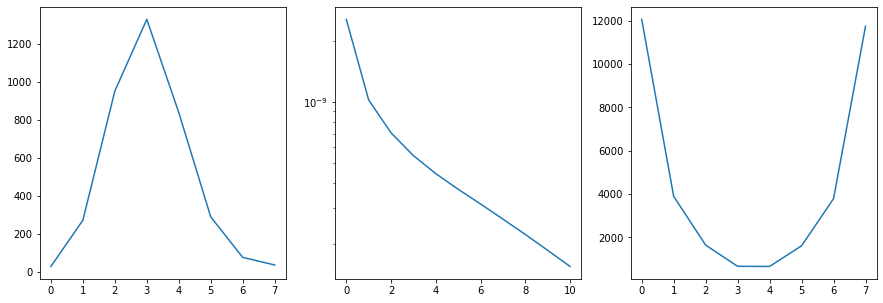

In [7]:
# plot mean signal
figure(figsize=[15,5])
subplot(131)
plot(pcounts.mean(axis=0))
subplot(132)
semilogy(ps.mean(axis=0))
subplot(133)
plot(l1norm.mean(axis=0))

In [8]:
import math
fov_rad=math.radians(5)
Omega_sky=pi*(fov_rad)**2#Omega_sky is defined as pi for my field ov view squared translated in radians
f_sky=Omega_sky/4/pi

In [9]:
# Computing covariance matrix
cov_ps=np.cov(ps, rowvar=False)*f_sky/0.25
cov_pcounts=np.cov(pcounts, rowvar=False)*f_sky/0.25
cov_comb=np.cov(comb, rowvar=False)*f_sky/0.25
cov_l1norm=np.cov(l1norm, rowvar=False)*f_sky/0.25

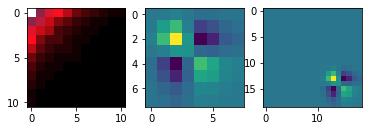

In [26]:
subplot(131)
imshow(cov_ps,cmap='gist_stern')
subplot(132)
imshow(cov_pcounts)
subplot(133)
imshow(cov_comb)

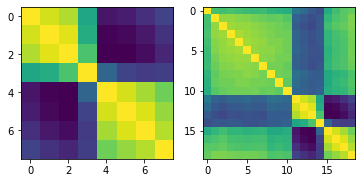

In [11]:
subplot(121)
imshow(np.corrcoef(pcounts.T))
subplot(122)
imshow(np.corrcoef(comb.T))

In [12]:
#Now, loading the jacobians of the power spectrum 
ps_jac = []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps/jac"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps/jac', filename), 'rb'))
        ps_jac.append(res['jac_ps'])

In [13]:
#Now, loading the jacobians of the peak counts
pcounts_jac= []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_peak_counts/jac"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_peak_counts/jac', filename), 'rb'))
        pcounts_jac.append(res['jac_pc'])

In [14]:
#Now, loading the jacobians of the l1norm
l1norm_jac= []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_l1norm/jac"):
        res =pickle.load(open(os.path.join('//global/cscratch1/sd/dlan/jacobian_l1norm/jac', filename), 'rb'))
        l1norm_jac.append(res['jac'])

In [15]:
ps_jac= stack(ps_jac, axis=0)
pcounts_jac = stack(pcounts_jac, axis=0)
comb_jac = concatenate([ps_jac,pcounts_jac[:77]], axis=1)
l1norm_jac= stack(l1norm_jac, axis=0)

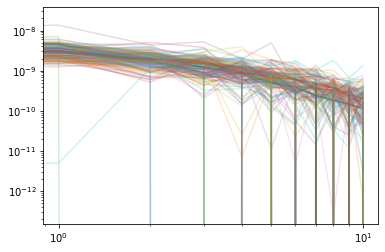

In [16]:
loglog(ps_jac.mean(axis=0))
for i in range(len(ps_jac)):
    loglog(ps_jac[i], alpha=0.2)

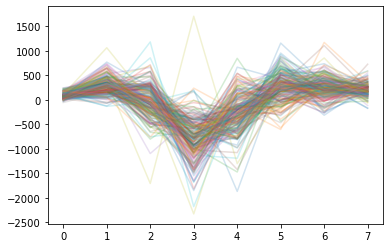

In [17]:
plot(pcounts_jac.mean(axis=0))
for i in range(len(pcounts_jac)):
    plot(pcounts_jac[i], alpha=0.2)

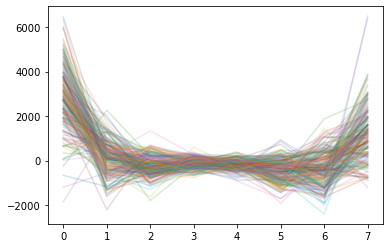

In [18]:
plot(l1norm_jac.mean(axis=0))
for i in range(len(l1norm_jac)):
    plot(l1norm_jac[i], alpha=0.2)

In [19]:
dmu_ps = ps_jac.mean(axis=0)
dmu_pcounts = pcounts_jac.mean(axis=0)
dmu_comb = comb_jac.mean(axis=0)
dmu_l1norm = l1norm_jac.mean(axis=0)

In [20]:
# Annnnd let's try to get our first fisher matrix
Fps = dmu_ps.T @ (np.linalg.inv(cov_ps)) @ dmu_ps

In [21]:
Fpcounts = dmu_pcounts.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts

In [22]:
Fcomb = dmu_comb.T @ (np.linalg.inv(cov_comb)) @ dmu_comb

In [23]:
Fl1norm = dmu_l1norm.T @ (np.linalg.inv(cov_l1norm)) @ dmu_l1norm

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

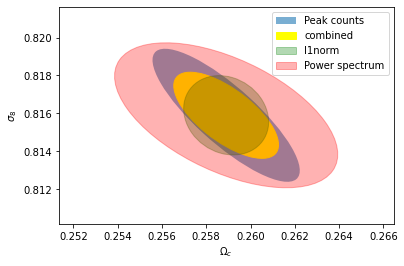

In [25]:
ax = plt.axes()
ax1=plot_contours(Fpcounts, [0.2589,
                  0.8159],alpha=1.6)
ax2=plot_contours(Fcomb, [0.2589,0.8159], color='yellow',alpha=1)
ax3=plot_contours(Fl1norm, [0.2589,
                  0.8159], color='green',alpha=0.3)
ax4=plot_contours(Fps, [0.2589,
                  0.8159], color='red',alpha=0.3)

xlabel('$\Omega_c$')
ylabel('$\sigma_8$')
plt.legend([ax1,ax2,ax3,ax4],['Peak counts','combined','l1norm', 'Power spectrum'])
# #savefig('Fisher.png',dpi=250)

### N.B. This is a different set of simulation 

In [27]:
labels=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$","$h$","$w_0$"]
params=[0.2589,0.8159,0.04860,0.9667,0.6774,-1.0]
xyrange=[[0.1,0.5],[0.6,0.9],[0.025,0.1],[0.8,1.2],[0.5,0.8],[-1.1,-0.9]]

In [28]:
#Now, loading the jacobians of the peak counts computed for more parameters 
pcounts_jac_corner= []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_peak_counts/jac2"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_peak_counts/jac2', filename), 'rb'))
        pcounts_jac_corner.append(res['jac_pc'])

In [29]:
#Now, loading the jacobians of the power spectrum computed for more parameters 
ps_jac_corner= []
for filename in os.listdir("/global/cscratch1/sd/dlan/jacobian_ps/jac2"):
        res =pickle.load(open(os.path.join('/global/cscratch1/sd/dlan/jacobian_ps/jac2', filename), 'rb'))
        ps_jac_corner.append(res['jac_ps'])

In [30]:
ps_jac_corner = stack(ps_jac_corner, axis=0)
pcounts_jac_corner = stack(pcounts_jac_corner, axis=0)

In [31]:
comb_jac_corner = concatenate([ps_jac_corner,pcounts_jac_corner[:80]], axis=1)

In [32]:
dmu_ps_corner = ps_jac_corner.mean(axis=0)
dmu_pcounts_corner = pcounts_jac_corner.mean(axis=0)
dmu_comb_corner = comb_jac_corner.mean(axis=0)

In [220]:
# def corner_plot(dmu,cov, params,colors,alpha,  nstd=1, labels=None):
#     r""" Makes a corner plot including all the parameters in the Fisher analysis
#     """
# #     if labels is None:
# #             labels = params
#     newFisher=[]
#     for i in range(len(params)):
#         for j in range(i):
#             ax = plt.subplot(len(params)-1, len(params)-1 , (i - 1)*(len(params)-1) + (j+1))
#             if i == len(params) - 1:
#                 ax.set_xlabel(labels[j])
#             else:
#                 ax.set_xticklabels([])
#             if j == 0:
#                 ax.set_ylabel(labels[i])
#             else:
#                 ax.set_yticklabels([])
                
#             new_dmu=np.take(dmu,[i,j],axis=1)
#             Fisher=new_dmu.T @ (np.linalg.inv(cov)) @ new_dmu
#             params_2D=np.array([params[j],params[i]])
#             if labels is None:
#                 labels = params_2D
#             plot_contours(Fisher, params_2D,nstd=nstd, ax=ax,color=colors,alpha=alpha)
            
#             xlim(xyrange[j][0],xyrange[j][1])
#             ylim(xyrange[i][0],xyrange[i][1])

#     plt.subplots_adjust(wspace=0)
#     plt.subplots_adjust(hspace=0)

In [ ]:
# ax = plt.axes()
# ax2=corner_plot(dmu_ps_corner,cov_ps, params,labels=labels, nstd=1,colors='green',alpha=0.3)
# ax1=corner_plot(dmu_comb_corner,cov_comb, params, nstd=1, labels=labels, colors='red',alpha=0.5)
# ax3=corner_plot(dmu_pcounts_corner,cov_pcounts, params, nstd=1, labels=labels,colors='purple',alpha=1.3)
# #plt.savefig("corner.png",dpi=250)

In [155]:
import itertools
from numpy import *
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.interpolate import interp1d

class fisher(object):
    """
    Base class to perform a Fisher Analysis from specified cosmology,
    survey and cosmological parameters.
    """

    def __init__(self, Fisher, params, fid_cosmo, margin_params=[]):
        """
        Constructor
        """
        self.params = params

        # Checks that the marginalisation parameters are actually considered
        # in the Fisher analysis
        self.margin_params = margin_params

        self.fid_cosmo = fid_cosmo

        # Precomputed Fisher matrix
        self._fullMat = Fisher
        self._fullInvMat = None
        self._mat = None
        self._invmat = None

    def Fij(self, param_i, param_j):
        """
            Returns the matrix element of the Fisher matrix for parameters
            param_i and param_j
        """
        i = self.params.index(param_i)
        j = self.params.index(param_j)

        return self.mat[i, j]

    def invFij(self, param_i, param_j):
        """
            Returns the matrix element of the inverse Fisher matrix for
            parameters param_i and param_j
        """
        i = self.params.index(param_i)
        j = self.params.index(param_j)

        return self.invmat[i, j]

    def sigma_fix(self, param):
        return 1.0 / sqrt(self.Fij(param, param))

    def sigma_marg(self, param):
        return sqrt(self.invFij(param, param))


    def _marginalise(self, params):
        r""" Marginalises the Fisher matrix over unwanted parameters.
        Parameters
        ----------
        params: list
            List of parameters that should not be marginalised over.
        Returns
        -------
        (mat, invmat): ndarray
            Marginalised Fisher matrix and its invers
        """
        # Builds inverse matrix
        marg_inv = zeros((len(params), len(params)))
        for i in range(len(params)):
            indi = self.params.index(params[i])
            for j in range(len(params)):
                indj = self.params.index(params[j])
                marg_inv[i, j] = self.invmat[indi, indj]

        marg_mat = linalg.pinv(marg_inv)

        return (marg_mat, marg_inv)

    def corner_plot(self, nstd=2, labels=None, **kwargs):
        r""" Makes a corner plot including all the parameters in the Fisher analysis
        """

        if labels is None:
            labels = self.params

        for i in range(len(self.params)):
            for j in range(i):
                ax = plt.subplot(len(self.params)-1, len(self.params)-1 , (i - 1)*(len(self.params)-1) + (j+1))
                if i == len(self.params) - 1:
                    ax.set_xlabel(labels[j])
                else:
                    ax.set_xticklabels([])
                if j == 0:
                    ax.set_ylabel(labels[i])
                else:
                    ax.set_yticklabels([])

                self.plot(self.params[j], self.params[i], nstd=nstd, ax=ax, **kwargs)

        plt.subplots_adjust(wspace=0)
        plt.subplots_adjust(hspace=0)

    def plot(self, p1, p2, nstd=2, ax=None, **kwargs):
        r""" Plots confidence contours corresponding to the parameters
        provided.
        Parameters
        ----------
        """
        params = [p1, p2]

        def eigsorted(cov):
            vals, vecs = linalg.eigh(cov)
            order = vals.argsort()[::-1]
            return vals[order], vecs[:, order]

        mat, cov = self._marginalise(params)
        # First find the fiducial value for the parameter in question
        fid_param = None
        pos = [0, 0]
        for p in params:
            fid_param = self.fid_cosmo[p]
            pos[params.index(p)] = fid_param

        if ax is None:
            ax = plt.gca()

        vals, vecs = eigsorted(cov)
        theta = degrees(arctan2(*vecs[:, 0][::-1]))

        # Width and height are "full" widths, not radius
        width, height = 2 * nstd * sqrt(vals)
        ellip = Ellipse(xy=pos, width=width,
                        height=height, angle=theta, **kwargs)

        ax.add_artist(ellip)
        sz = max(width, height)
        s1 = 1.5*nstd*self.sigma_marg(p1)
        s2 = 1.5*nstd*self.sigma_marg(p2)
        ax.set_xlim(pos[0] - s1, pos[0] + s1)
        ax.set_ylim(pos[1] - s2, pos[1] + s2)
        #ax.set_xlim(pos[0] - sz, pos[0] + sz)
        #ax.set_ylim(pos[1] - sz, pos[1] + sz)
        plt.draw()
        return ellip

    @property
    def FoM_DETF(self):
        """
            Computes the figure of merit from the Dark Energy Task Force
            Albrecht et al 2006
            FoM = 1/sqrt(det(F^-1_{w0,wa}))
        """
        det = (self.invFij('w0', 'w0') * self.invFij('wa', 'wa') -
               self.invFij('wa', 'w0') * self.invFij('w0', 'wa'))
        return 1.0 / sqrt(det)

    @property
    def FoM(self):
        """
            Total figure of merit : ln (1/det(F^{-1}))
        """
        return log(1.0 / abs(linalg.det(self.invmat)))

    @property
    def invmat(self):
        """
        Returns the inverse fisher matrix
        """
        if self._invmat is None:
            self._invmat = linalg.inv(self.mat)
        return self._invmat

    @property
    def mat(self):
        """
        Returns the fisher matrix marginalised over nuisance parameters
        """
        # If the matrix is not already computed, compute it
        if self._mat is None:
            self._fullInvMat = linalg.pinv(self._fullMat)

            # Apply marginalisation over nuisance parameters
            self._invmat = self._fullInvMat[0:len(self.params),
                                           0:len(self.params)]

            self._mat = linalg.pinv(self._invmat)
        return self._mat

In [156]:
# The way to use this:
fid_cosmo = {"$\Omega_c$": 0.2589,
             "$\sigma8$": 0.8159,
             "$\Omega_b$": 0.04860,
             "$n_s$": 0.9667,
             "$h$": 0.6774,
             "$w_0$": -1.0}

In [157]:
Fisher_ps=dmu_ps_corner.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_corner

In [158]:
Fisher_pcounts=dmu_pcounts_corner.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts_corner

In [159]:
Fisher_comb=dmu_comb_corner.T @ (np.linalg.inv(cov_comb)) @dmu_comb_corner

In [160]:
fisher_object_ps = fisher(Fisher_ps, labels,  fid_cosmo)
fisher_object_pcounts = fisher(Fisher_pcounts, labels,  fid_cosmo)
fisher_object_comb = fisher(Fisher_comb, labels,  fid_cosmo)

<ipython-input-155-d246c6d4242f>:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(len(self.params)-1, len(self.params)-1 , (i - 1)*(len(self.params)-1) + (j+1))


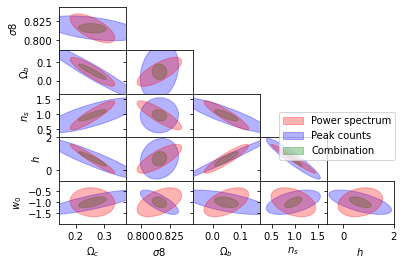

In [161]:

fisher_object_pcounts.corner_plot(color='blue',alpha=1.3)
fisher_object_comb.corner_plot(color='green',alpha=1.3)
fisher_object_ps.corner_plot(color='red',alpha=1.3)
red_patch = mpatches.Patch(color='red', label='Power spectrum',alpha=1.3)
blue_patch = mpatches.Patch(color='blue', label='Peak counts',alpha=1.3)
green_patch = mpatches.Patch(color='green', label='Combination',alpha=1.3)
plt.legend(handles=[red_patch,blue_patch,green_patch],loc='upper right', bbox_to_anchor=(1.1, 2.7))
#plt.savefig("corner.png",dpi=250)


In [162]:
fid_cosmo_rid = {"$\Omega_c$": 0.2589,
            "$\sigma8$": 0.8159,
             "$\Omega_b$": 0.04860,
             "$n_s$": 0.9667}
labels_rid=["$\Omega_c$","$\sigma8$","$\Omega_b$","$n_s$"]

In [163]:
dmu_ps_corner_rid=dmu_ps_corner[...,0:5]
dmu_pcounts_corner_rid=dmu_pcounts_corner[...,0:5]
dmu_comb_corner_rid=dmu_comb_corner[...,0:5]

In [164]:
Fisher_ps_rid=dmu_ps_corner_rid.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_corner_rid
Fisher_pcounts_rid=dmu_pcounts_corner_rid.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts_corner_rid
Fisher_comb_rid=dmu_comb_corner_rid.T @ (np.linalg.inv(cov_comb)) @dmu_comb_corner_rid

In [165]:
fisher_object_ps_rid = fisher(Fisher_ps_rid, labels_rid,  fid_cosmo_rid )
fisher_object_pcounts_rid = fisher(Fisher_pcounts_rid, labels_rid,  fid_cosmo_rid )
fisher_object_comb_rid = fisher(Fisher_comb_rid, labels_rid,  fid_cosmo_rid )

<ipython-input-155-d246c6d4242f>:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(len(self.params)-1, len(self.params)-1 , (i - 1)*(len(self.params)-1) + (j+1))


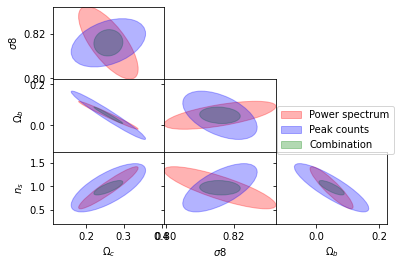

In [166]:
import matplotlib.patches as mpatches
fisher_object_ps_rid.corner_plot(color='red',alpha=1.3)
fisher_object_comb_rid.corner_plot(color='green',alpha=1.3)
fisher_object_pcounts_rid.corner_plot(color='blue',alpha=1.3)
red_patch = mpatches.Patch(color='red', label='Power spectrum',alpha=1.3)
blue_patch = mpatches.Patch(color='blue', label='Peak counts',alpha=1.3)
green_patch = mpatches.Patch(color='green', label='Combination',alpha=1.3)
plt.legend(handles=[red_patch,blue_patch,green_patch],loc='upper right', bbox_to_anchor=(1.1, 1.7))


In [167]:
fid_cosmo2par = {"$\Omega_c$": 0.2589,
            "$\sigma8$": 0.8159}
labels2par=["$\Omega_c$","$\sigma8$"]

In [168]:
dmu_ps_corner2par=dmu_ps_corner[...,0:2]
dmu_pcounts_corner2par=dmu_pcounts_corner[...,0:2]
dmu_comb_corner2par=dmu_comb_corner[...,0:2]

In [169]:
Fisher_ps2par=dmu_ps_corner2par.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_corner2par
Fisher_pcounts2par=dmu_pcounts_corner2par.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts_corner2par
Fisher_comb2par=dmu_comb_corner2par.T @ (np.linalg.inv(cov_comb)) @dmu_comb_corner2par

In [170]:
fisher_object_ps2par = fisher(Fisher_ps2par, labels2par,  fid_cosmo2par )
fisher_object_pcounts2par = fisher(Fisher_pcounts2par, labels2par,  fid_cosmo2par )
fisher_object_comb2par = fisher(Fisher_comb2par, labels2par,  fid_cosmo2par )

<ipython-input-155-d246c6d4242f>:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(len(self.params)-1, len(self.params)-1 , (i - 1)*(len(self.params)-1) + (j+1))


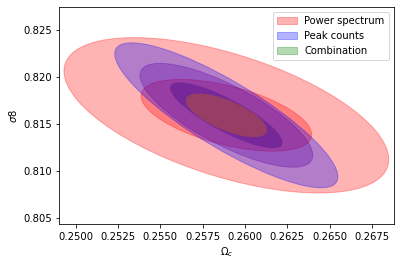

In [171]:
fisher_object_ps2par.corner_plot(color='red',alpha=1.3)
fisher_object_comb2par.corner_plot(color='purple',alpha=1.3)
fisher_object_pcounts2par.corner_plot(color='blue',alpha=1.3)
red_patch = mpatches.Patch(color='red', label='Power spectrum',alpha=1.3)
blue_patch = mpatches.Patch(color='blue', label='Peak counts',alpha=1.3)
green_patch = mpatches.Patch(color='green', label='Combination',alpha=1.3)
plt.legend(handles=[red_patch,blue_patch,green_patch],loc='upper right')

In [172]:
fid_cosmo2par_fin = { "$h$": 0.6774,
             "$w_0$": -1.0}
labels2par_fin=["$h$","$w_0$"]

In [173]:
dmu_ps_corner2par_fin=dmu_ps_corner[...,-2:]
dmu_pcounts_corner2par_fin=dmu_pcounts_corner[...,-2:]
dmu_comb_corner2par_fin=dmu_comb_corner[...,-2:]

In [174]:
Fisher_ps2par_fin=dmu_ps_corner2par_fin.T @ (np.linalg.inv(cov_ps)) @ dmu_ps_corner2par_fin
Fisher_pcounts2par_fin=dmu_pcounts_corner2par_fin.T @ (np.linalg.inv(cov_pcounts)) @ dmu_pcounts_corner2par_fin
Fisher_comb2par_fin=dmu_comb_corner2par_fin.T @ (np.linalg.inv(cov_comb)) @dmu_comb_corner2par_fin

In [175]:
fisher_object_ps2par_fin = fisher(Fisher_ps2par_fin, labels2par_fin,  fid_cosmo2par_fin )
fisher_object_pcounts2par_fin = fisher(Fisher_pcounts2par_fin, labels2par_fin,  fid_cosmo2par_fin )
fisher_object_comb2par_fin = fisher(Fisher_comb2par_fin, labels2par_fin,  fid_cosmo2par_fin )

<ipython-input-155-d246c6d4242f>:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(len(self.params)-1, len(self.params)-1 , (i - 1)*(len(self.params)-1) + (j+1))


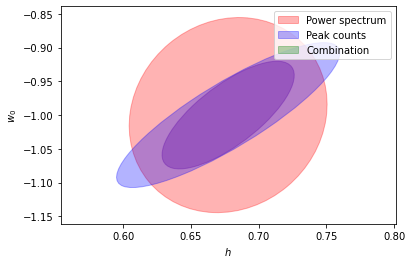

In [176]:
fisher_object_ps2par_fin.corner_plot(color='red',alpha=1.3)
fisher_object_comb2par_fin.corner_plot(color='purple',alpha=1.3)
fisher_object_pcounts2par_fin.corner_plot(color='blue',alpha=1.3)
red_patch = mpatches.Patch(color='red', label='Power spectrum',alpha=1.3)
blue_patch = mpatches.Patch(color='blue', label='Peak counts',alpha=1.3)
green_patch = mpatches.Patch(color='green', label='Combination',alpha=1.3)
plt.legend(handles=[red_patch,blue_patch,green_patch],loc='upper right')